# Which plan brings in more revenue?

I work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the two plans brings in more revenue in order to adjust the advertising budget.

I am going to carry out a preliminary analysis of the plans based on the data of 500 Megaline clients. The data gives me information on who the clients are, where they're from, which plan they use, the number of calls they made, and the number of text messages they sent in 2018. The analysis should help me determine which of the two plans is more profitable.

## Initialization

First let's load all of the libraries that will be used.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats as st
import seaborn as sns

## Load data

Now let's load the data files into different DataFrames.

In [2]:
plans = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users.csv')
calls = pd.read_csv('megaline_calls.csv')
messages = pd.read_csv('megaline_messages.csv')
internet = pd.read_csv('megaline_internet.csv')

## Prepare the data

Some of the methods used to clean the DataFrames below include the following: 

1) Dropping duplicates (if any).

2) Checking that the data types are correct.

3) Renaming some of the columns for clarity.

4) Rearranging some of the columns into a more logical order.

## Plans

The **info** function is a convenient way to find general/summary information about a DataFrame.

In [3]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


Since the dataframe has only 2 rows, it is easy to display it and see what it looks like.

In [4]:
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


### Fix data

The order of the columns in the plans DataFrame is awkward. For one, it would make sense to put the plan_name first, but it appears last. 

Furthermore, it would make sense to "group" the following columns together: 

(1) minutes_included & usd_per_minute 

(2) messages_included & usd_per_message 

(3) mb_per_month_included & usd_per_gb. 

The following code makes these changes.

In [5]:
plans = plans[['plan_name','usd_monthly_pay','minutes_included','usd_per_minute',
               'messages_included','usd_per_message', 'mb_per_month_included', 'usd_per_gb']]

display(plans)

,plan_name,usd_monthly_pay,minutes_included,usd_per_minute,messages_included,usd_per_message,mb_per_month_included,usd_per_gb
0,surf,20,500,0.03,50,0.03,15360,10
1,ultimate,70,3000,0.01,1000,0.01,30720,7


### Enrich data

It makes sense to add a **gb_per_month_included** column because users get charged for every GB of data that exceeds the package limit, not for every MB, so this column will help with calculating revenue later on.

In [6]:
plans['gb_per_month_included'] = (plans['mb_per_month_included'] / 1000)


plans = plans[['plan_name','usd_monthly_pay','minutes_included','usd_per_minute',
               'messages_included','usd_per_message', 'mb_per_month_included', 
               'gb_per_month_included', 'usd_per_gb']]

display(plans)

,plan_name,usd_monthly_pay,minutes_included,usd_per_minute,messages_included,usd_per_message,mb_per_month_included,gb_per_month_included,usd_per_gb
0,surf,20,500,0.03,50,0.03,15360,15.36,10
1,ultimate,70,3000,0.01,1000,0.01,30720,30.72,7


## Users

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Let's print a sample of 15 rows to get a feel for what this DataFrame "looks like".

In [8]:
display(users.sample(15))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
149,1149,Jamaal,Camacho,54,"San Francisco-Oakland-Berkeley, CA MSA",2018-03-03,surf,NaN
37,1037,Reena,Velazquez,20,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-11,ultimate,NaN
54,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ MSA",2018-04-21,surf,2018-12-31
65,1065,Sherlyn,Noel,26,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-08-03,surf,NaN
303,1303,Rosamaria,Reeves,67,"Detroit-Warren-Dearborn, MI MSA",2018-10-25,ultimate,NaN
327,1327,Natosha,Peck,20,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-17,surf,NaN
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07
426,1426,Lamont,Conner,44,"San Francisco-Oakland-Berkeley, CA MSA",2018-07-09,ultimate,NaN
138,1138,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-02-06,surf,NaN


### Fix Data

For some strange reason, in the **city** column USA was mistakingly written as "MSA". The code below fixes this.

In [9]:
users['city'] = users['city'].replace('MSA', 'USA', regex = True)

It seems strange to me that subscription date is abbreviated as "reg_date", so the code below changes the abbreviation to "sub_date".


In [10]:
users = users.rename(columns = {'reg_date': 'sub_date'})

Since the **plans** DataFrame names the column with "surf" and "ultimate" as values as **plan_name** instead of merely **plan**, it makes sense for the users DataFrame to have this column be renamed to **plan_name**.

In [11]:
users = users.rename(columns = {'plan': 'plan_name'})

It is always a good idea to use the **drop_duplicates()** function just in case there are any rows which are exact duplicates.

In [12]:
users = users.drop_duplicates()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   sub_date    500 non-null    object
 6   plan_name   500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Enrich Data

It would be nice to have a DataFrame of only the users who are active.

In [13]:
active_users = users[users['churn_date'].isna()]

active_users = active_users.drop(columns = 'churn_date')

active_users = active_users.reset_index(drop = True)

display(active_users)

,user_id,first_name,last_name,age,city,sub_date,plan_name
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA USA",2018-12-24,ultimate
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA USA",2018-08-13,surf
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV USA",2018-10-21,surf
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK USA",2018-01-28,surf
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA USA",2018-05-23,surf
...,...,...,...,...,...,...,...
461,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA USA",2018-09-04,surf
462,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA USA",2018-02-20,surf
463,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA USA",2018-12-10,ultimate
464,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA USA",2018-02-04,surf


Similarly, it would be nice to have a DataFrame of only the users who are inactive.

In [14]:
inactive_users = users[~users['churn_date'].isna()].copy()

It seems appropriate to enrich the inactive_users DataFrame by adding a column that displays the number of days each inactive user used their subscription before ending it. I will use **sub_len_days** ("subscription length in days") as the name of this column.

In [15]:
inactive_users['sub_len_days'] = pd.to_datetime(inactive_users['churn_date']) - pd.to_datetime(inactive_users['sub_date'])

inactive_users['sub_len_days'] = inactive_users['sub_len_days'].astype(str)

inactive_users['sub_len_days'] = inactive_users['sub_len_days'].replace('days', '', regex = True)

inactive_users['sub_len_days'] = inactive_users['sub_len_days'].astype(int)

inactive_users = inactive_users.reset_index(drop = True)

display(inactive_users)

,user_id,first_name,last_name,age,city,sub_date,plan_name,churn_date,sub_len_days
0,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA USA",2018-11-27,ultimate,2018-12-18,21
1,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI USA",2018-06-28,surf,2018-11-16,141
2,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA USA",2018-04-20,surf,2018-09-07,140
3,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD USA",2018-12-23,surf,2018-12-30,7
4,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL USA",2018-03-20,ultimate,2018-10-07,201
5,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ USA",2018-04-21,surf,2018-12-31,254
6,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI USA",2018-09-24,surf,2018-11-24,61
7,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA USA",2018-10-26,surf,2018-12-18,53
8,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL USA",2018-06-04,surf,2018-11-11,160
9,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA USA",2018-10-30,surf,2018-12-12,43


While we are at it, I would argue that it would be nice to plot the distribution of the subscription lengths.

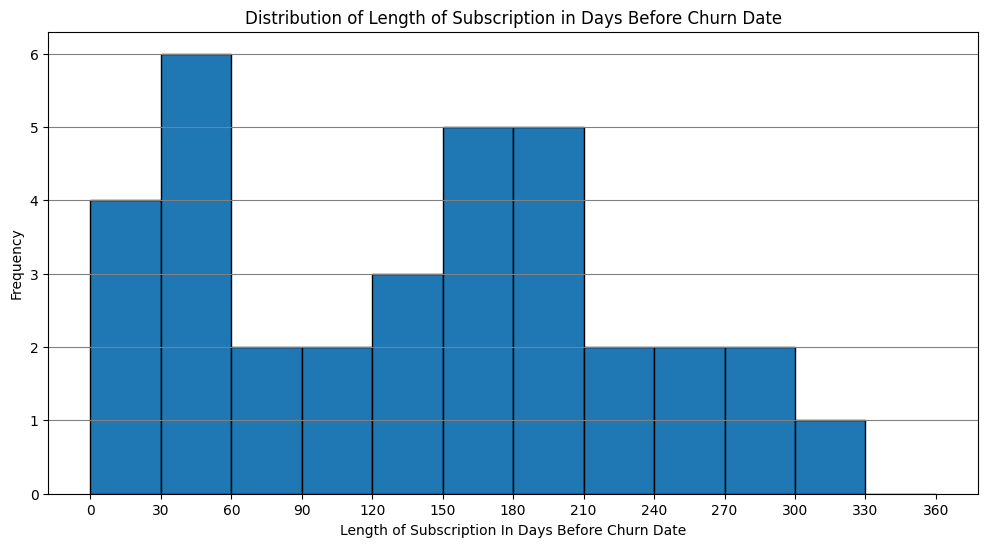

In [16]:
sub_len_days = inactive_users['sub_len_days'].copy()

sub_len_days.plot(kind = 'hist',
                  bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360],
                  edgecolor = 'black',
                  figsize = (12, 6),
                  title = 'Distribution of Length of Subscription in Days Before Churn Date')

plt.grid(axis = 'y', color = 'gray')
plt.xlabel('Length of Subscription In Days Before Churn Date')
plt.xticks(np.arange(0, 390, step = 30))
plt.show()

In the histogram above, I deliberately set the bin and xtick step to 30 because one month is either approximately or exactly 30 days, hence the histogram gives viewers an idea of how many months these users used their subscription before their churn date. 
    
Users are charged by their monthly usage of call minutes, message sending, and Internet, so Megaline stakeholders might find it helpful to know how many months these users used their subscription before calling it quits. This sort of data is especially useful if the company wants to try to persuade these users to come back, such as by sending them an email with a discount code.

In [17]:
sub_len_days.describe()

count     34.000000
mean     141.647059
std       88.464984
min        7.000000
25%       59.000000
50%      152.000000
75%      200.250000
max      313.000000
Name: sub_len_days, dtype: float64

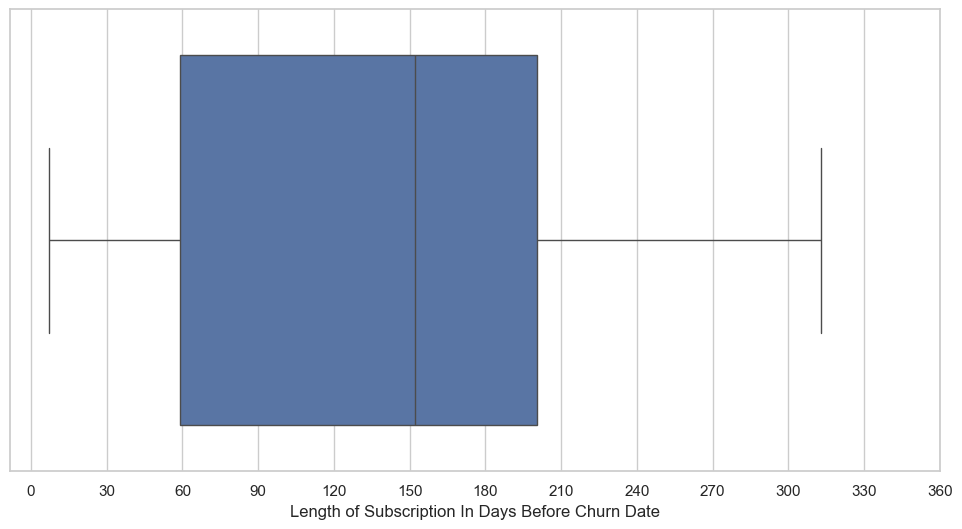

In [18]:
sns.set(rc = {"figure.figsize": (12, 6)})
sns.set_style("whitegrid")

sub_len_days_boxplot = sns.boxplot(data = sub_len_days, orient = 'h')

plt.xlabel('Length of Subscription In Days Before Churn Date')
plt.xticks(np.arange(0, 390, step = 30))
plt.yticks([])
plt.show()

In theory, I could have plotted the distributions of former Surf users and former Ultimate users seperately, but in this case doing so would not be a good idea because I only have 23 former Surf users and 11 former Ultimate users to work with. These sample sizes are too small to be useful for acquiring accurate statistics about the population of former Megaline users. With that said, if more data about these former users were available, Megaline stakeholders would surely benefit from knowing, among other values, the mean, standard deviation, and quartile values of the lengths of the subscriptions.

## Calls

In [19]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [20]:
display(calls.sample(15))

,id,user_id,call_date,duration
64275,1232_598,1232,2018-11-21,8.06
108951,1385_21,1385,2018-11-04,2.79
112966,1397_686,1397,2018-12-15,0.00
77421,1277_497,1277,2018-05-14,5.51
122450,1433_21,1433,2018-12-01,8.96
115445,1404_239,1404,2018-10-04,12.44
65440,1237_47,1237,2018-10-24,4.37
128241,1460_328,1460,2018-07-08,0.00
132436,1476_392,1476,2018-10-29,9.68
56326,1201_428,1201,2018-08-20,11.18


### Fix data

In [21]:
calls = calls.drop_duplicates()
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


The column name **id** is ambiguous and potentially misleading, so it should be renamed to **call_id**.

In [22]:
calls = calls.rename(columns = {'id': 'call_id'})

I think the Dataframe would look better by having **user_id** be the first column.

In [23]:
calls = calls[['user_id', 'call_id', 'call_date', 'duration']]

Regarding calls, Megaline rounds seconds up to minutes for each individual call, so I apply the ceil function to the **duration** column. I also change that column's Dtype from float to integer.

In [24]:
calls['duration'] = np.ceil(calls['duration'])

calls['duration'] = calls['duration'].astype(int)

display(calls)

,user_id,call_id,call_date,duration
0,1000,1000_93,2018-12-27,9
1,1000,1000_145,2018-12-27,14
2,1000,1000_247,2018-12-27,15
3,1000,1000_309,2018-12-28,6
4,1000,1000_380,2018-12-30,5
...,...,...,...,...
137730,1499,1499_199,2018-11-21,9
137731,1499,1499_200,2018-10-20,11
137732,1499,1499_201,2018-09-21,9
137733,1499,1499_202,2018-10-10,1


## Messages

In [25]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [26]:
messages.sample(15)

,id,user_id,message_date
20178,1128_147,1128,2018-09-30
14037,1098_25,1098,2018-11-10
62298,1392_73,1392,2018-12-07
6083,1055_201,1055,2018-11-05
60901,1383_139,1383,2018-11-18
67797,1439_191,1439,2018-07-20
31819,1196_305,1196,2018-07-20
30235,1189_173,1189,2018-09-26
1346,1011_309,1011,2018-12-12
67886,1439_280,1439,2018-12-10


### Fix data

In [27]:
messages = messages.drop_duplicates()
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


The column name **id** is ambiguous and potentially misleading, so it should be renamed to **message_id**.

In [28]:
messages = messages.rename(columns = {'id': 'message_id'})

I think it would make sense to make **user_id** the first column.

In [29]:
messages = messages[['user_id', 'message_id', 'message_date']]

display(messages)

,user_id,message_id,message_date
0,1000,1000_125,2018-12-27
1,1000,1000_160,2018-12-31
2,1000,1000_223,2018-12-31
3,1000,1000_251,2018-12-27
4,1000,1000_255,2018-12-26
...,...,...,...
76046,1497,1497_526,2018-12-24
76047,1497,1497_536,2018-12-24
76048,1497,1497_547,2018-12-31
76049,1497,1497_558,2018-12-24


## Internet

In [30]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [31]:
display(internet.sample(15))

,id,user_id,session_date,mb_used
79837,1373_116,1373,2018-11-10,167.09
56189,1254_124,1254,2018-12-08,154.79
82628,1385_379,1385,2018-04-13,325.62
104121,1498_183,1498,2018-03-16,459.92
2116,1010_295,1010,2018-10-04,512.05
92006,1427_11,1427,2018-10-12,668.29
41683,1185_720,1185,2018-10-10,520.35
66147,1305_372,1305,2018-09-14,461.53
60455,1273_412,1273,2018-10-18,0.24
2405,1011_145,1011,2018-09-07,247.97


### Fix data

In [32]:
internet = internet.drop_duplicates()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


The column name **id** is ambiguous and potentially misleading, so it should be renamed to **session_id**.

In [33]:
internet = internet.rename(columns = {'id': 'session_id'})

I think it would make sense to make **user_id** the first column.

In [34]:
internet = internet[['user_id', 'session_id', 'session_date', 'mb_used']]

display(internet)

,user_id,session_id,session_date,mb_used
0,1000,1000_13,2018-12-29,89.86
1,1000,1000_204,2018-12-31,0.00
2,1000,1000_379,2018-12-28,660.40
3,1000,1000_413,2018-12-26,270.99
4,1000,1000_442,2018-12-27,880.22
...,...,...,...,...
104820,1499,1499_215,2018-10-20,218.06
104821,1499,1499_216,2018-12-30,304.72
104822,1499,1499_217,2018-09-22,292.75
104823,1499,1499_218,2018-12-07,0.00


## Study plan conditions

In [35]:
display(plans)

,plan_name,usd_monthly_pay,minutes_included,usd_per_minute,messages_included,usd_per_message,mb_per_month_included,gb_per_month_included,usd_per_gb
0,surf,20,500,0.03,50,0.03,15360,15.36,10
1,ultimate,70,3000,0.01,1000,0.01,30720,30.72,7


## Aggregate data per user

Now that the data is clean, I should aggregate the data per user per period in order to have just one record. This should ease the further analysis a lot.

Let's calculate the number of calls made by each user per month.

In [36]:
calls_per_month = calls[['user_id', 'call_id', 'call_date']].copy()

calls_per_month['call_date'] = calls_per_month['call_date'].str.split('-').str[1]

# The line above rewrites the 'call_date' to include only the month.
# Doing this will help with analyzing the data by a monthly basis.

calls_per_month.columns = ['user_id', 'call_id', 'month']

calls_per_month['month'] = calls_per_month['month'].astype(int)

calls_per_month = calls_per_month.groupby(['user_id', 'month']).count()

calls_per_month = calls_per_month.rename(columns = {'call_id':'call_count'})

calls_per_month = calls_per_month.reset_index()

display(calls_per_month)

,user_id,month,call_count
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


Now let's calculate the amount of minutes spent by each user per month.

In [37]:
minutes_per_month = calls[['user_id', 'duration', 'call_date']].copy()

minutes_per_month['call_date'] = minutes_per_month['call_date'].str.split('-').str[1]

minutes_per_month.columns = ['user_id', 'duration', 'month']

minutes_per_month['month'] = minutes_per_month['month'].astype(int)

minutes_per_month = minutes_per_month.groupby(['user_id', 'month']).sum()

minutes_per_month = minutes_per_month.rename(columns = {'duration':'call_minutes_sum'})

minutes_per_month = minutes_per_month.reset_index()

display(minutes_per_month)

,user_id,month,call_minutes_sum
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2253,1498,12,339
2254,1499,9,346
2255,1499,10,385
2256,1499,11,308


Now let's calculate the number of messages sent by each user per month.

In [38]:
messages_per_month = messages[['user_id', 'message_id', 'message_date']].copy()

messages_per_month['message_date'] = messages_per_month['message_date'].str.split('-').str[1]

messages_per_month.columns = ['user_id', 'message_id', 'month']

messages_per_month['month'] = messages_per_month['month'].astype(int)

messages_per_month = messages_per_month.groupby(['user_id', 'month']).count()

messages_per_month = messages_per_month.rename(columns = {'message_id':'message_count'})

messages_per_month = messages_per_month.reset_index()

display(messages_per_month)

,user_id,month,message_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


Now let's calculate the volume of internet traffic used by each user per month.

In [39]:
internet_per_month = internet[['user_id', 'mb_used', 'session_date']].copy()

internet_per_month['session_date'] = internet_per_month['session_date'].str.split('-').str[1]

internet_per_month.columns = ['user_id', 'mb_used', 'month']

internet_per_month['month'] = internet_per_month['month'].astype(int)

internet_per_month = internet_per_month.groupby(['user_id', 'month']).sum()

internet_per_month = internet_per_month.rename(columns = {'mb_used':'mb_used_sum'})

# It makes sense to add a 'gb_used_sum' column because users get charged for every GB of data that exceeds 
# the package limit, not for every MB, so this column will help with calculating revenue later on.

internet_per_month['gb_used_sum'] = internet_per_month['mb_used_sum'] / 1000

internet_per_month = internet_per_month[['mb_used_sum', 'gb_used_sum']]

internet_per_month = internet_per_month.reset_index()

display(internet_per_month)

,user_id,month,mb_used_sum,gb_used_sum
0,1000,12,1901.47,1.90147
1,1001,8,6919.15,6.91915
2,1001,9,13314.82,13.31482
3,1001,10,22330.49,22.33049
4,1001,11,18504.30,18.50430
...,...,...,...,...
2272,1498,12,23137.69,23.13769
2273,1499,9,12984.76,12.98476
2274,1499,10,19492.43,19.49243
2275,1499,11,16813.83,16.81383


In the next line, I merge the data for calls, minutes, messages, internet based on **user_id** and **month**.

Notice that I fill all of the null values with 0. Doing this makes sense because if a user is missing a calls, minutes, messages, and / or internet value, it means the user simply did not use that service during the month with a missing value.

In [40]:
users_by_month = calls_per_month.merge(minutes_per_month, how = 'outer')
users_by_month = users_by_month.merge(messages_per_month, how = 'outer')
users_by_month = users_by_month.merge(internet_per_month, how = 'outer')

users_by_month = users_by_month.fillna(0)

users_by_month['call_count'] = users_by_month['call_count'].astype(int)
users_by_month['call_minutes_sum'] = users_by_month['call_minutes_sum'].astype(int)
users_by_month['message_count'] = users_by_month['message_count'].astype(int)

users_by_month = users_by_month.sort_values(by = ['user_id', 'month'], ascending = True)

# The line above sorts the DataFrame by ascending values of user_id AND month, making it easy to view the 
# behavior of each user on a month by month basis.

users_by_month = users_by_month.reset_index(drop = True)

display(users_by_month)

,user_id,month,call_count,call_minutes_sum,message_count,mb_used_sum,gb_used_sum
0,1000,12,16,124,11,1901.47,1.90147
1,1001,8,27,182,30,6919.15,6.91915
2,1001,9,49,315,44,13314.82,13.31482
3,1001,10,65,393,53,22330.49,22.33049
4,1001,11,64,426,36,18504.30,18.50430
...,...,...,...,...,...,...,...
2288,1498,12,39,339,0,23137.69,23.13769
2289,1499,9,41,346,0,12984.76,12.98476
2290,1499,10,53,385,0,19492.43,19.49243
2291,1499,11,45,308,0,16813.83,16.81383


Now I will add the plan information to the **users_by_month** DataFrame.

In [41]:
users_by_month = users_by_month.merge(users[['user_id','plan_name']])

users_by_month = users_by_month.merge(plans)

users_by_month = users_by_month[['user_id', 'plan_name', 'usd_monthly_pay', 'month', 'call_count', 
                                 'call_minutes_sum', 'minutes_included', 'usd_per_minute', 
                                 'message_count', 'messages_included', 'usd_per_message', 'mb_used_sum',
                                 'mb_per_month_included', 'gb_used_sum', 'gb_per_month_included', 'usd_per_gb']]

# I think it makes sense to put the plan name right next to the user_id, hence the purpose of the line above.

users_by_month = users_by_month.sort_values(by = ['user_id', 'month'], ascending = True)

users_by_month = users_by_month.reset_index(drop = True)

display(users_by_month)

,user_id,plan_name,usd_monthly_pay,month,call_count,call_minutes_sum,minutes_included,usd_per_minute,message_count,messages_included,usd_per_message,mb_used_sum,mb_per_month_included,gb_used_sum,gb_per_month_included,usd_per_gb
0,1000,ultimate,70,12,16,124,3000,0.01,11,1000,0.01,1901.47,30720,1.90147,30.72,7
1,1001,surf,20,8,27,182,500,0.03,30,50,0.03,6919.15,15360,6.91915,15.36,10
2,1001,surf,20,9,49,315,500,0.03,44,50,0.03,13314.82,15360,13.31482,15.36,10
3,1001,surf,20,10,65,393,500,0.03,53,50,0.03,22330.49,15360,22.33049,15.36,10
4,1001,surf,20,11,64,426,500,0.03,36,50,0.03,18504.30,15360,18.50430,15.36,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,surf,20,12,39,339,500,0.03,0,50,0.03,23137.69,15360,23.13769,15.36,10
2289,1499,surf,20,9,41,346,500,0.03,0,50,0.03,12984.76,15360,12.98476,15.36,10
2290,1499,surf,20,10,53,385,500,0.03,0,50,0.03,19492.43,15360,19.49243,15.36,10
2291,1499,surf,20,11,45,308,500,0.03,0,50,0.03,16813.83,15360,16.81383,15.36,10


I will now create a new DataFrame to store the monthly revenue values. A good place to start is appending the monthly charges as these values will be added to however much additional revenue was made from calls, messages, and Internet usage.

In [42]:
monthly_revenue_by_user = pd.DataFrame()

monthly_revenue_by_user['usd_monthly_pay'] = users_by_month['usd_monthly_pay']

Now I will add a column that shows how much additional revenue, if any, was made from phone calls.

Since not every user exceeds the minutes limit of their package, some users will have negative revenue values. A negative revenue value does not make sense in this context, so to fix this the code below will replace every negative revenue value with a 0.

In [43]:
monthly_revenue_by_user['call_revenue'] = (users_by_month['call_minutes_sum'] - users_by_month['minutes_included']) * users_by_month['usd_per_minute']

monthly_revenue_by_user.loc[monthly_revenue_by_user['call_revenue'] < 0, 'call_revenue'] = 0

display(monthly_revenue_by_user)

,usd_monthly_pay,call_revenue
0,70,0.0
1,20,0.0
2,20,0.0
3,20,0.0
4,20,0.0
...,...,...
2288,20,0.0
2289,20,0.0
2290,20,0.0
2291,20,0.0


Now I will add a column that shows how much additional revenue, if any, was made from messages.

In [44]:
monthly_revenue_by_user['message_revenue'] = (users_by_month['message_count'] - users_by_month['messages_included']) * users_by_month['usd_per_message']

monthly_revenue_by_user.loc[monthly_revenue_by_user['message_revenue'] < 0, 'message_revenue'] = 0

display(monthly_revenue_by_user)

,usd_monthly_pay,call_revenue,message_revenue
0,70,0.0,0.00
1,20,0.0,0.00
2,20,0.0,0.00
3,20,0.0,0.09
4,20,0.0,0.00
...,...,...,...
2288,20,0.0,0.00
2289,20,0.0,0.00
2290,20,0.0,0.00
2291,20,0.0,0.00


Now I will add a column that shows how much additional revenue, if any, was made from internet usage.

Notice the use of the np.ceil function in the code below. However many gigabytes a user uses that surpasses their package's limit, Megaline rounds this number up to the nearest integer. (For example, if a user goes 1.025 megabytes over their limit, the user will be charged for 2 additional gigabytes.)

In [45]:
monthly_revenue_by_user['internet_revenue'] = np.ceil(users_by_month['gb_used_sum'] - users_by_month['gb_per_month_included']) * users_by_month['usd_per_gb']

monthly_revenue_by_user.loc[monthly_revenue_by_user['internet_revenue'] < 0, 'internet_revenue'] = 0

display(monthly_revenue_by_user)

,usd_monthly_pay,call_revenue,message_revenue,internet_revenue
0,70,0.0,0.00,0.0
1,20,0.0,0.00,0.0
2,20,0.0,0.00,0.0
3,20,0.0,0.09,70.0
4,20,0.0,0.00,40.0
...,...,...,...,...
2288,20,0.0,0.00,80.0
2289,20,0.0,0.00,0.0
2290,20,0.0,0.00,50.0
2291,20,0.0,0.00,20.0


Finally, I will add a column that contains the sum of all of the revenue values that are in the same row.

In [46]:
monthly_revenue_by_user['total_revenue'] = monthly_revenue_by_user['usd_monthly_pay'] + monthly_revenue_by_user['call_revenue'] + monthly_revenue_by_user['message_revenue'] + monthly_revenue_by_user['internet_revenue']

display(monthly_revenue_by_user)

,usd_monthly_pay,call_revenue,message_revenue,internet_revenue,total_revenue
0,70,0.0,0.00,0.0,70.00
1,20,0.0,0.00,0.0,20.00
2,20,0.0,0.00,0.0,20.00
3,20,0.0,0.09,70.0,90.09
4,20,0.0,0.00,40.0,60.00
...,...,...,...,...,...
2288,20,0.0,0.00,80.0,100.00
2289,20,0.0,0.00,0.0,20.00
2290,20,0.0,0.00,50.0,70.00
2291,20,0.0,0.00,20.0,40.00


It would make sense to now merge the **monthly_revenue_by_user** DataFrame with the **users_by_month** DataFrame.

In [47]:
users_by_month['call_revenue'] = monthly_revenue_by_user['call_revenue']

users_by_month['message_revenue'] = monthly_revenue_by_user['message_revenue']

users_by_month['internet_revenue'] = monthly_revenue_by_user['internet_revenue']

users_by_month['total_revenue'] = monthly_revenue_by_user['total_revenue']

display(users_by_month)

,user_id,plan_name,usd_monthly_pay,month,call_count,call_minutes_sum,minutes_included,usd_per_minute,message_count,messages_included,usd_per_message,mb_used_sum,mb_per_month_included,gb_used_sum,gb_per_month_included,usd_per_gb,call_revenue,message_revenue,internet_revenue,total_revenue
0,1000,ultimate,70,12,16,124,3000,0.01,11,1000,0.01,1901.47,30720,1.90147,30.72,7,0.0,0.00,0.0,70.00
1,1001,surf,20,8,27,182,500,0.03,30,50,0.03,6919.15,15360,6.91915,15.36,10,0.0,0.00,0.0,20.00
2,1001,surf,20,9,49,315,500,0.03,44,50,0.03,13314.82,15360,13.31482,15.36,10,0.0,0.00,0.0,20.00
3,1001,surf,20,10,65,393,500,0.03,53,50,0.03,22330.49,15360,22.33049,15.36,10,0.0,0.09,70.0,90.09
4,1001,surf,20,11,64,426,500,0.03,36,50,0.03,18504.30,15360,18.50430,15.36,10,0.0,0.00,40.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,surf,20,12,39,339,500,0.03,0,50,0.03,23137.69,15360,23.13769,15.36,10,0.0,0.00,80.0,100.00
2289,1499,surf,20,9,41,346,500,0.03,0,50,0.03,12984.76,15360,12.98476,15.36,10,0.0,0.00,0.0,20.00
2290,1499,surf,20,10,53,385,500,0.03,0,50,0.03,19492.43,15360,19.49243,15.36,10,0.0,0.00,50.0,70.00
2291,1499,surf,20,11,45,308,500,0.03,0,50,0.03,16813.83,15360,16.81383,15.36,10,0.0,0.00,20.0,40.00


I see no good reason to keep the mb values columns since I have the gb values columns.

In [48]:
users_by_month = users_by_month.drop(columns = ['mb_used_sum', 'mb_per_month_included'])

In [49]:
users_by_month = users_by_month[['user_id', 'plan_name', 'month', 'call_count', 'call_minutes_sum', 
                                'minutes_included', 'usd_per_minute', 'message_count', 'messages_included', 
                                'usd_per_message', 'gb_used_sum', 'gb_per_month_included', 'usd_per_gb', 
                                'usd_monthly_pay', 'call_revenue', 'message_revenue', 'internet_revenue', 
                                'total_revenue']]

# The 'usd_monthly_pay' column is now to the left of the 'call_revenue' column, just like how it is in
# monthly_revenue_by_user, to help make it easier to see why the 'total_revenue' values are what they are.

display(users_by_month)

,user_id,plan_name,month,call_count,call_minutes_sum,minutes_included,usd_per_minute,message_count,messages_included,usd_per_message,gb_used_sum,gb_per_month_included,usd_per_gb,usd_monthly_pay,call_revenue,message_revenue,internet_revenue,total_revenue
0,1000,ultimate,12,16,124,3000,0.01,11,1000,0.01,1.90147,30.72,7,70,0.0,0.00,0.0,70.00
1,1001,surf,8,27,182,500,0.03,30,50,0.03,6.91915,15.36,10,20,0.0,0.00,0.0,20.00
2,1001,surf,9,49,315,500,0.03,44,50,0.03,13.31482,15.36,10,20,0.0,0.00,0.0,20.00
3,1001,surf,10,65,393,500,0.03,53,50,0.03,22.33049,15.36,10,20,0.0,0.09,70.0,90.09
4,1001,surf,11,64,426,500,0.03,36,50,0.03,18.50430,15.36,10,20,0.0,0.00,40.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,surf,12,39,339,500,0.03,0,50,0.03,23.13769,15.36,10,20,0.0,0.00,80.0,100.00
2289,1499,surf,9,41,346,500,0.03,0,50,0.03,12.98476,15.36,10,20,0.0,0.00,0.0,20.00
2290,1499,surf,10,53,385,500,0.03,0,50,0.03,19.49243,15.36,10,20,0.0,0.00,50.0,70.00
2291,1499,surf,11,45,308,500,0.03,0,50,0.03,16.81383,15.36,10,20,0.0,0.00,20.0,40.00


## Study user behaviour

### Calls

Let's plot a bar graph that compares the average duration of calls per each plan per each distinct month.

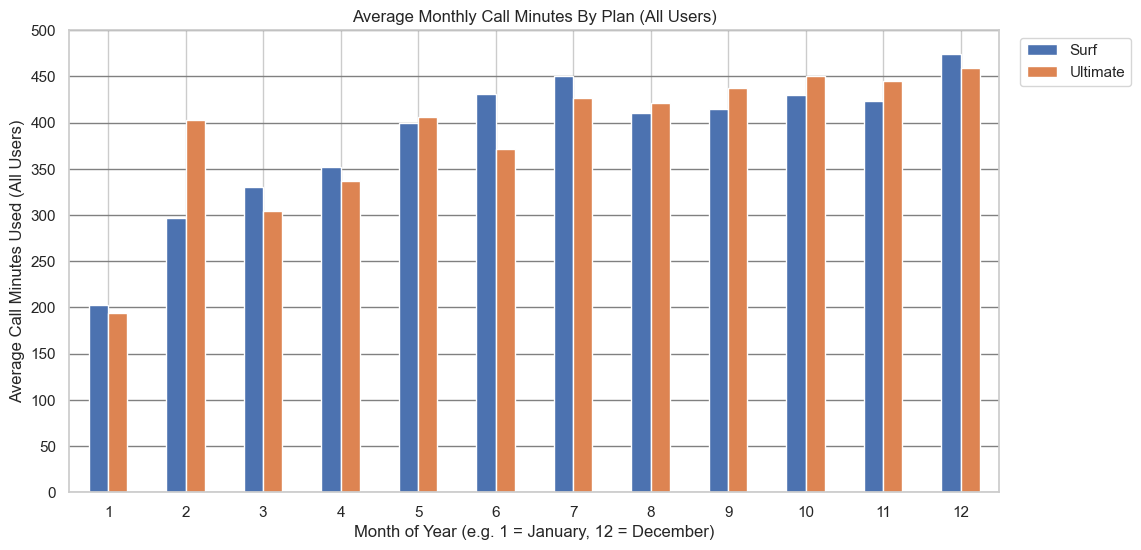

In [50]:
average_call_duration = pd.DataFrame()
average_call_duration = users_by_month[['plan_name', 'month', 'call_minutes_sum']]

average_call_duration_surf = average_call_duration[average_call_duration['plan_name'] == 'surf']
average_call_duration_surf = average_call_duration_surf.drop(columns = 'plan_name')
average_call_duration_surf = average_call_duration_surf.groupby('month').mean()
average_call_duration_surf = average_call_duration_surf.rename(columns = {'call_minutes_sum': 'call_minutes_avg'})

average_call_duration_ultimate = average_call_duration[average_call_duration['plan_name'] == 'ultimate']
average_call_duration_ultimate = average_call_duration_ultimate.drop(columns = 'plan_name')
average_call_duration_ultimate = average_call_duration_ultimate.groupby('month').mean()
average_call_duration_ultimate = average_call_duration_ultimate.rename(columns = {'call_minutes_sum': 'call_minutes_avg'})

surf_and_ultimate_avg_minutes = pd.concat([average_call_duration_surf, average_call_duration_ultimate], axis = 'columns')
surf_and_ultimate_avg_minutes.columns = ['surf_call_minutes_avg', 'ultimate_call_minutes_avg']

surf_and_ultimate_avg_minutes.plot(kind = 'bar',
                                   figsize = (12, 6),
                                   title = 'Average Monthly Call Minutes By Plan (All Users)',
                                   xlabel = 'Month of Year (e.g. 1 = January, 12 = December)',
                                   ylabel = 'Average Call Minutes Used (All Users)',
                                   y = ['surf_call_minutes_avg', 'ultimate_call_minutes_avg'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 550, step = 50))
plt.show()

Let's compare the number of minutes users of each plan require each month using a histogram.

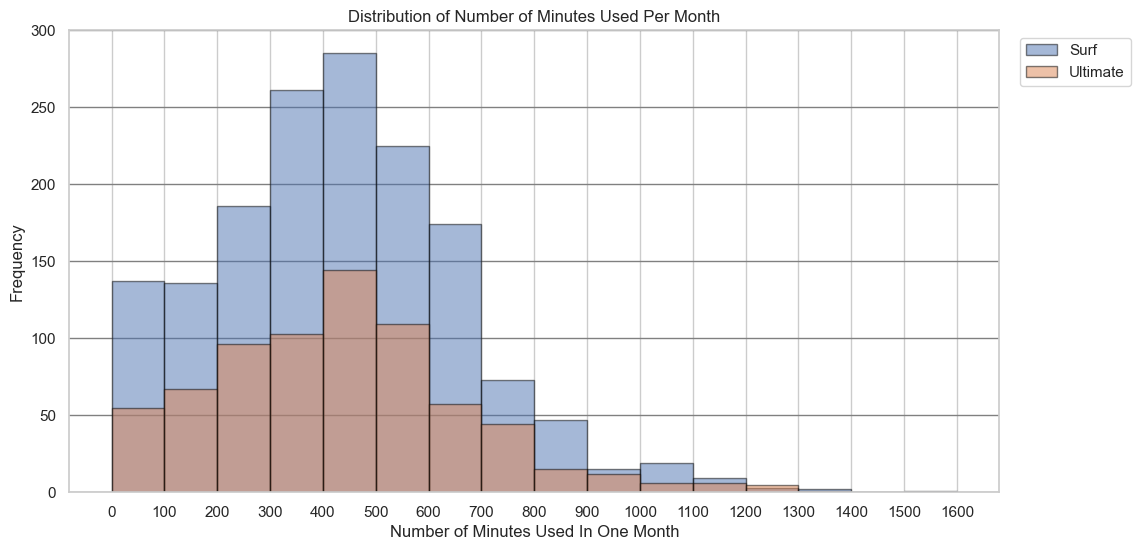

In [51]:
monthly_minutes_surf = pd.DataFrame()
monthly_minutes_surf = users_by_month[users_by_month['plan_name'] == 'surf']['call_minutes_sum']
monthly_minutes_surf = monthly_minutes_surf.reset_index(drop = True)

monthly_minutes_surf.plot(kind = 'hist',
                          alpha = 0.5,
                          bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600],
                          edgecolor = 'black',
                          figsize = (12, 6),
                          title = 'Distribution of Number of Minutes Used Per Month')

monthly_minutes_ultimate = pd.DataFrame()
monthly_minutes_ultimate = users_by_month[users_by_month['plan_name'] == 'ultimate']['call_minutes_sum']
monthly_minutes_ultimate = monthly_minutes_ultimate.reset_index(drop = True)

monthly_minutes_ultimate.plot(kind = 'hist', 
                              alpha = 0.5,
                              bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600],
                              edgecolor = 'black')

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xlabel('Number of Minutes Used In One Month')
plt.xticks(np.arange(0, 1700, step = 100))
plt.yticks(np.arange(0, 350, step = 50))
plt.show()

In addition to calculating the mean and the variance of the monthly call duration, I decided to calculate other summary statistics to help me see the "full picture" of user behavior regarding calling. Furthermore, the DataFrame below will help me ensure that my histogram and boxplot are accurate.

In [52]:
monthly_minutes_summary_stats = pd.DataFrame()

monthly_minutes_summary_stats['plan_name'] = ['surf', 'ultimate']

monthly_minutes_summary_stats['count'] = [monthly_minutes_surf.count(), monthly_minutes_ultimate.count()]

monthly_minutes_summary_stats['mean'] = [monthly_minutes_surf.mean(), monthly_minutes_ultimate.mean()]

monthly_minutes_summary_stats['variance'] = [monthly_minutes_surf.var(), monthly_minutes_ultimate.var()]

monthly_minutes_summary_stats['standard_deviation'] = [monthly_minutes_surf.std(), monthly_minutes_ultimate.std()]

monthly_minutes_summary_stats['minimum'] = [monthly_minutes_surf.min(), monthly_minutes_ultimate.min()]

monthly_minutes_summary_stats['25th_Percentile'] = [np.percentile(monthly_minutes_surf, 25), np.percentile(monthly_minutes_ultimate, 25)]

monthly_minutes_summary_stats['50th_Percentile'] = [monthly_minutes_surf.median(), monthly_minutes_ultimate.median()]

monthly_minutes_summary_stats['75th_Percentile'] = [np.percentile(monthly_minutes_surf, 75), np.percentile(monthly_minutes_ultimate, 75)]

monthly_minutes_summary_stats['maximum'] = [monthly_minutes_surf.max(), monthly_minutes_ultimate.max()]

display(monthly_minutes_summary_stats)

,plan_name,count,mean,variance,standard_deviation,minimum,25th_Percentile,50th_Percentile,75th_Percentile,maximum
0,surf,1573,428.749523,54968.279461,234.453150,0,272.0,425.0,576.00,1510
1,ultimate,720,430.450000,57844.464812,240.508762,0,260.0,424.0,565.25,1369


Now let's plot a boxplot to visualize the distribution of the monthly call durations.

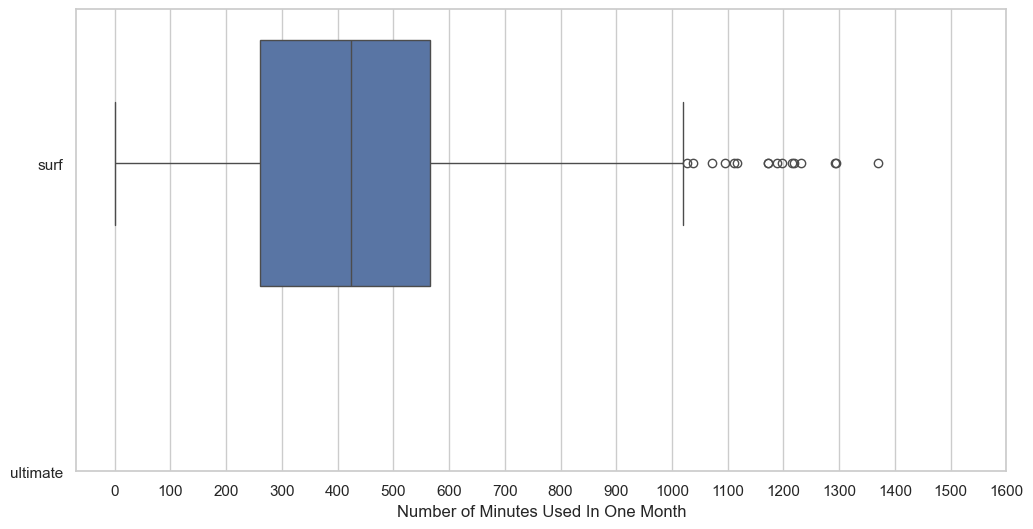

In [53]:
monthly_calls_boxplot = sns.boxplot(data = [monthly_minutes_surf, monthly_minutes_ultimate], orient = 'h')

plt.xlabel('Number of Minutes Used In One Month')
plt.xticks(np.arange(0, 1700, step = 100))
plt.yticks([0, 1], labels = ['surf', 'ultimate'])
plt.show()

<b>Call Minutes Conclusion</b> 
    
Interestingly, the behavior of the Surf users with regards to call minutes is hardly any different from that of the Ultimate users. As shown by the bar graph, the only month where the average number of call minutes was dramatically different was February, during which Ultimate's average call minutes was a little more 100 higher than that of Surf.
    
Even though the Ultimate plan permits many more call minutes before additional charges, 3000 minutes compared to 500 minutes, neither plan ever had a monthly average that reached 500 minutes. Oddly enough, in six out of the twelves months (specifically, January, March, April, June, July, and December) the average number of call minutes was slightly higher for Surf than Ultimate.
    
The histogram and boxplot do any especially good job of showing how similar the distributions of the two plans are. Both distributions are right–tailed (also called positively–skewed), meaning both have outliers on the right end of the graphs. Furthermore, both distributions have remarkably similar summary statistics, including a similar mean (428.749523 for Surf, 430.45 for Ultimate), a pretty similar standard deviation (234.45315 compared to 240.508762), and very similar median (425 compared to 424).
    
Lastly, it is worth noting that not one Ultimate plan user exceeded their monthly minutes limit of 3000. In fact, the maximum number of call minutes used by an Ultimate user was less than half the limit, 1369 minutes. This seems to me to be good evidence that the Ultimate plan provides ample call minutes for nearly anyone. In contrast, the 75th percentile number of call minutes used by Surf users is 576, meaning significantly more than 25% of Surf users exceed their monthly limit of 500 call minutes.

### Messages

Now let's do an analysis, akin to the analysis done with the calls data, of the messages data.

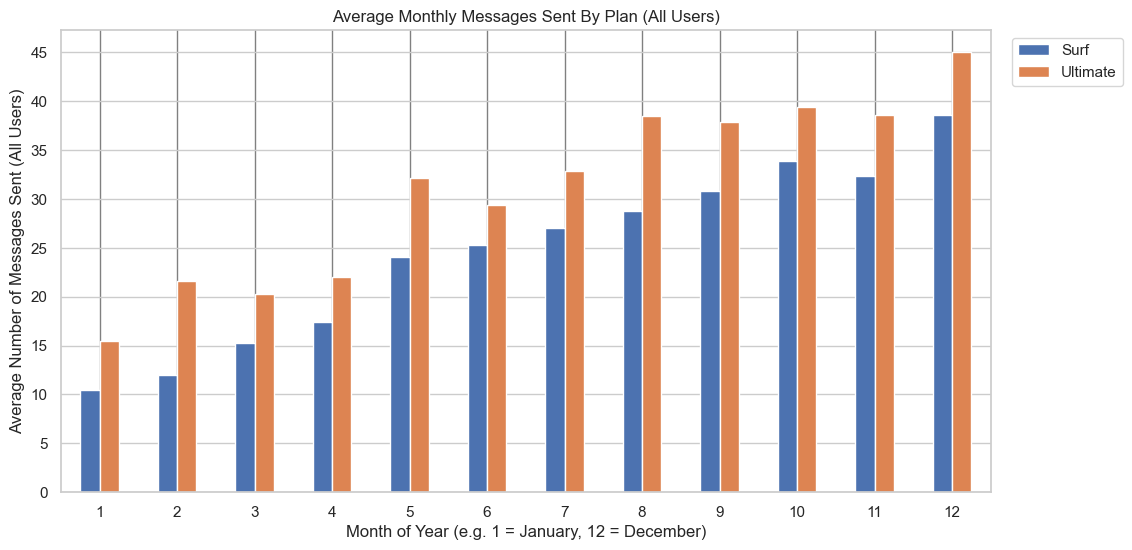

In [54]:
average_message_count = pd.DataFrame()
average_message_count = users_by_month[['plan_name', 'month', 'message_count']]

average_message_count_surf = average_message_count[average_message_count['plan_name'] == 'surf']
average_message_count_surf = average_message_count_surf.drop(columns = 'plan_name')
average_message_count_surf = average_message_count_surf.groupby('month').mean()
average_message_count_surf = average_message_count_surf.rename(columns = {'message_count': 'message_count_avg'})

average_message_count_ultimate = average_message_count[average_call_duration['plan_name'] == 'ultimate']
average_message_count_ultimate = average_message_count_ultimate.drop(columns = 'plan_name')
average_message_count_ultimate = average_message_count_ultimate.groupby('month').mean()
average_message_count_ultimate = average_message_count_ultimate.rename(columns = {'call_minutes_sum': 'call_minutes_avg'})

surf_and_ultimate_avg_messages = pd.concat([average_message_count_surf, average_message_count_ultimate], 
                                           axis = 'columns')

surf_and_ultimate_avg_messages.columns = ['surf_message_avg', 'ultimate_message_avg']

surf_and_ultimate_avg_messages.plot(kind = 'bar',
                                    figsize = (12, 6),
                                    title = 'Average Monthly Messages Sent By Plan (All Users)',
                                    xlabel = 'Month of Year (e.g. 1 = January, 12 = December)',
                                    ylabel = 'Average Number of Messages Sent (All Users)',
                                    y = ['surf_message_avg', 'ultimate_message_avg'])

plt.grid(axis = 'x', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 50, step = 5))
plt.show()

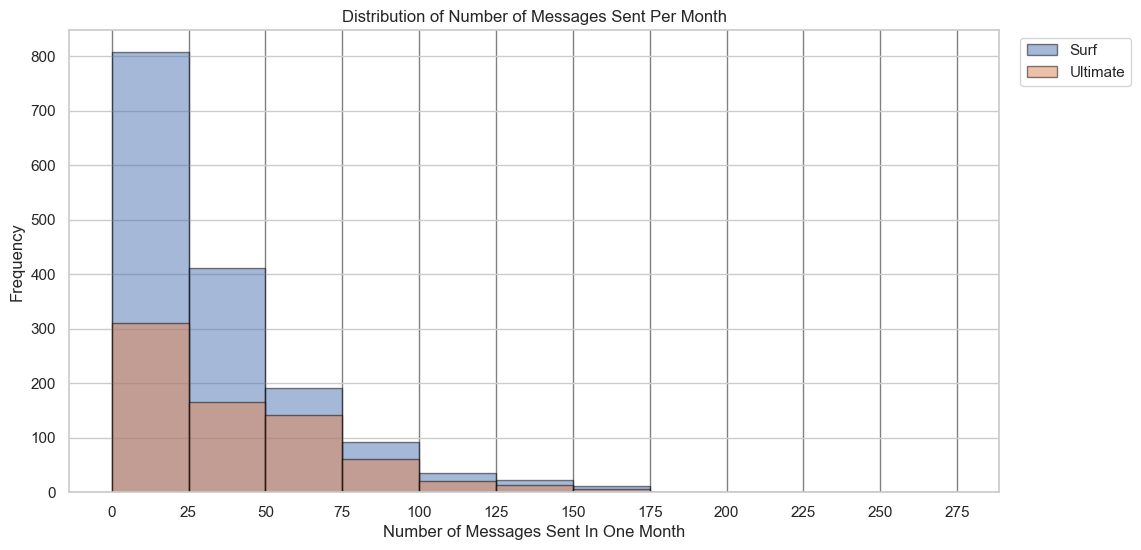

In [55]:
monthly_messages_surf = pd.DataFrame()
monthly_messages_surf = users_by_month[users_by_month['plan_name'] == 'surf']['message_count']
monthly_messages_surf = monthly_messages_surf.reset_index(drop = True)

monthly_messages_surf.plot(kind = 'hist',
                           alpha = 0.5,
                           bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275],
                           edgecolor = 'black',
                           figsize = (12, 6),
                           title = 'Distribution of Number of Messages Sent Per Month')

monthly_messages_ultimate = pd.DataFrame()
monthly_messages_ultimate = users_by_month[users_by_month['plan_name'] == 'ultimate']['message_count']
monthly_messages_ultimate = monthly_messages_ultimate.reset_index(drop = True)

monthly_messages_ultimate.plot(kind = 'hist', 
                               alpha = 0.5,
                               bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275],
                               edgecolor = 'black')

plt.grid(axis = 'x', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xlabel('Number of Messages Sent In One Month')
plt.xticks(np.arange(0, 300, step = 25))
plt.yticks(np.arange(0, 900, step = 100))
plt.show()

In [56]:
monthly_messages_summary_stats = pd.DataFrame()

monthly_messages_summary_stats['plan_name'] = ['surf', 'ultimate']

monthly_messages_summary_stats['count'] = [monthly_messages_surf.count(), monthly_messages_ultimate.count()]

monthly_messages_summary_stats['mean'] = [monthly_messages_surf.mean(), monthly_messages_ultimate.mean()]

monthly_messages_summary_stats['variance'] = [monthly_messages_surf.var(), monthly_messages_ultimate.var()]

monthly_messages_summary_stats['standard_deviation'] = [monthly_messages_surf.std(), monthly_messages_ultimate.std()]

monthly_messages_summary_stats['minimum'] = [monthly_messages_surf.min(), monthly_messages_ultimate.min()]

monthly_messages_summary_stats['25th_Percentile'] = [np.percentile(monthly_messages_surf, 25), np.percentile(monthly_messages_ultimate, 25)]

monthly_messages_summary_stats['50th_Percentile'] = [monthly_messages_surf.median(), monthly_messages_ultimate.median()]

monthly_messages_summary_stats['75th_Percentile'] = [np.percentile(monthly_messages_surf, 75), np.percentile(monthly_messages_ultimate, 75)]

monthly_messages_summary_stats['maximum'] = [monthly_messages_surf.max(), monthly_messages_ultimate.max()]

display(monthly_messages_summary_stats)

,plan_name,count,mean,variance,standard_deviation,minimum,25th_Percentile,50th_Percentile,75th_Percentile,maximum
0,surf,1573,31.159568,1126.724522,33.566717,0,3.0,24.0,47.0,266
1,ultimate,720,37.551389,1208.756744,34.767179,0,7.0,30.0,61.0,166


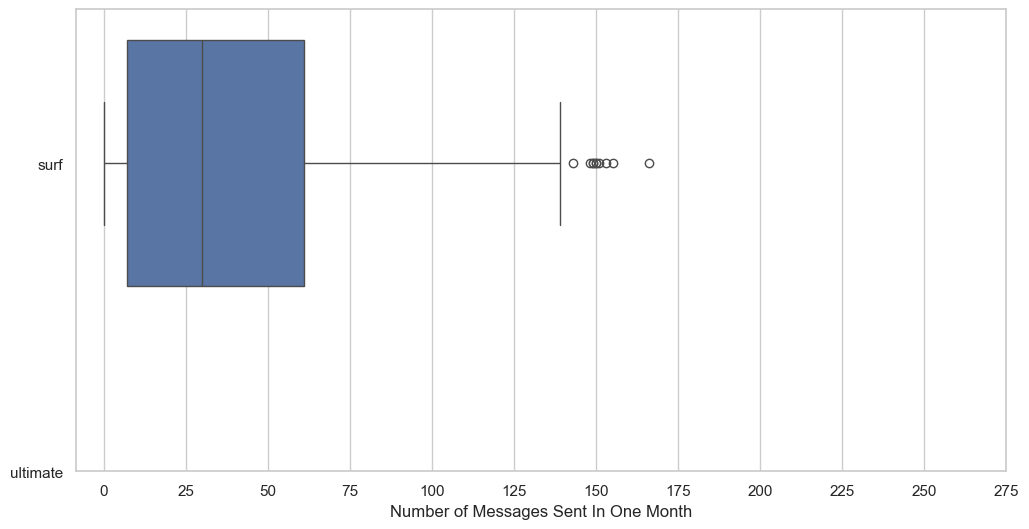

In [57]:
monthly_messages_boxplot = sns.boxplot(data = [monthly_messages_surf, monthly_messages_ultimate], orient = 'h')

plt.xlabel('Number of Messages Sent In One Month')
plt.xticks(np.arange(0, 300, step = 25))
plt.yticks([0, 1], labels = ['surf', 'ultimate'])
plt.show()

<b>Messages Conclusion</b> 
    
Though the distributions of the two plans are both right–tailed, there are some notable differences between them.
    
As shown by the bar graph, in all twelve months of the year users of the Ultimate plan, on average, sent more messages, with the monthly average for Ultimate usually being at least 5 more than that of Surf. This is different from the bar graph of the average number of call minutes used, where in six months out of twelve it was actually Surf that had the higher average.
    
The average number of messages sent by Surf users was 31.159568, which is noticably smaller than that of Ultimate, 37.551389. Oddly enough though, both distributions have very similar standard deviations, 33.566717 for Surf and 34.767179 for Ultimate. That aside, the median for Surf is noticably smaller than that of Ultimate, 24 compared to 30, and there is an especially big difference in their 75th percentile values, 47 versus 61.
    
The differences in values mentioned above is likely the natural result of Surf users being limited to 50 messages per month, whereas Ultimate users are limited to a whopping 1000 messages per month. What's interesting about Surf's 75th percentile value being 47 is that it shows how over 75% of the time Surf users successfully prevent themselves from going over their limit. That said, there is a considerable minority of them that send many more than 50 messages per month. In fact, the Surf distribution has MANY more outliers than the Ultimate distribution.
    
Though the Ultimate distribution has a handful of outliers, relative to the majority of the data values, even its maximum value of 166 messages sent in a month is still FAR less than the limit of 1000. Just like with call minutes, I see this as good evidence that the Ultimate plan allows an ample number of messages for nearly everyone.

### Internet

Let's see what the graphs and distributions look like for the internet traffic consumed data.

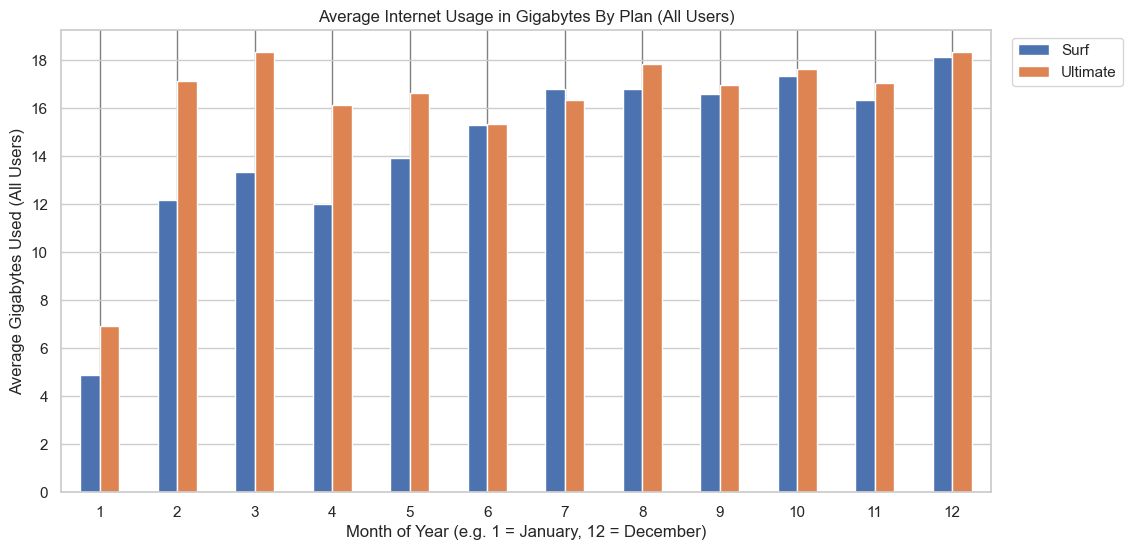

In [58]:
average_internet_gb = pd.DataFrame()
average_internet_gb = users_by_month[['plan_name', 'month', 'gb_used_sum']]

average_internet_gb_surf = average_internet_gb[average_internet_gb['plan_name'] == 'surf']
average_internet_gb_surf = average_internet_gb_surf.drop(columns = 'plan_name')
average_internet_gb_surf = average_internet_gb_surf.groupby('month').mean()
average_internet_gb_surf = average_internet_gb_surf.rename(columns = {'message_count': 'message_count_avg'})

average_internet_gb_ultimate = average_internet_gb[average_internet_gb['plan_name'] == 'ultimate']
average_internet_gb_ultimate = average_internet_gb_ultimate.drop(columns = 'plan_name')
average_internet_gb_ultimate = average_internet_gb_ultimate.groupby('month').mean()
average_internet_gb_ultimate = average_internet_gb_ultimate.rename(columns = {'gb_used_sum': 'gb_used_avg'})

surf_and_ultimate_avg_internet = pd.concat([average_internet_gb_surf, average_internet_gb_ultimate], 
                                           axis = 'columns')

surf_and_ultimate_avg_internet.columns = ['surf_internet_avg', 'ultimate_internet_avg']

surf_and_ultimate_avg_internet.plot(kind = 'bar',
                                    figsize = (12, 6),
                                    title = 'Average Internet Usage in Gigabytes By Plan (All Users)',
                                    xlabel = 'Month of Year (e.g. 1 = January, 12 = December)',
                                    ylabel = 'Average Gigabytes Used (All Users)',
                                    y = ['surf_internet_avg', 'ultimate_internet_avg'])

plt.grid(axis = 'x', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 20, step = 2))
plt.show()

I find it intriguing how from January to May the average Internet usage of Surf users was noticably lower, by at least 2 GB, than that of Ultimate users, yet for the rest of the year the monthly average values were approximately the same. Despite the differences from January to May, the distributions of the two plans end up being remarkably similar, as shown by the histogram and boxplot below.

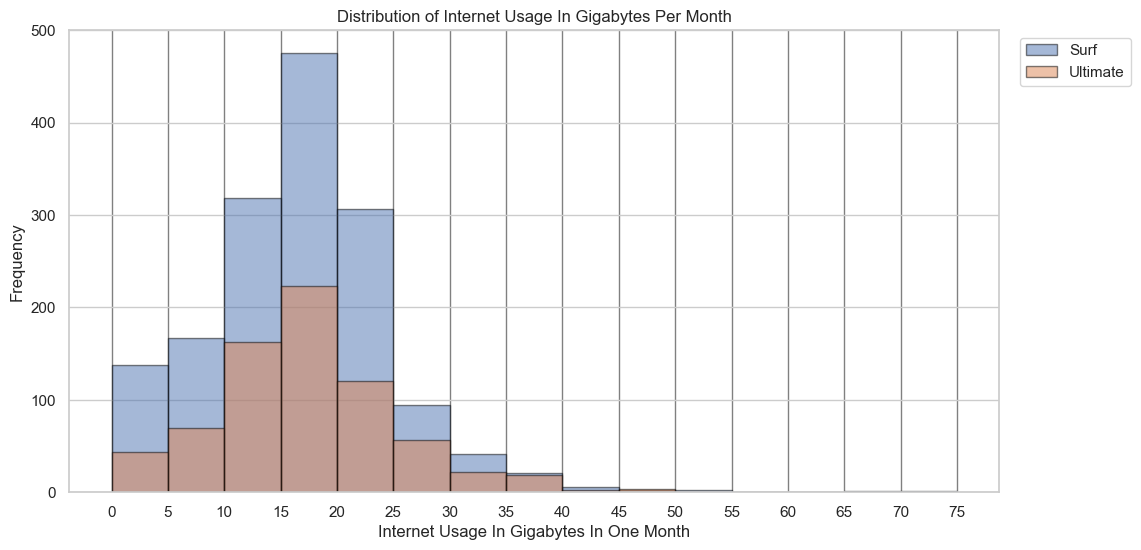

In [59]:
monthly_internet_surf = pd.DataFrame()
monthly_internet_surf = users_by_month[users_by_month['plan_name'] == 'surf']['gb_used_sum']
monthly_internet_surf = monthly_internet_surf.reset_index(drop = True)

monthly_internet_surf.plot(kind = 'hist',
                           alpha = 0.5,
                           bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
                           edgecolor = 'black',
                           figsize = (12, 6),
                           title = 'Distribution of Internet Usage In Gigabytes Per Month')

monthly_internet_ultimate = pd.DataFrame()
monthly_internet_ultimate = users_by_month[users_by_month['plan_name'] == 'ultimate']['gb_used_sum']
monthly_internet_ultimate = monthly_internet_ultimate.reset_index(drop = True)

monthly_internet_ultimate.plot(kind = 'hist', 
                               alpha = 0.5,
                               bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
                               edgecolor = 'black')

plt.grid(axis = 'x', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xlabel('Internet Usage In Gigabytes In One Month')
plt.xticks(np.arange(0, 80, step = 5))
plt.yticks(np.arange(0, 600, step = 100))
plt.show()

In [60]:
monthly_internet_summary_stats = pd.DataFrame()

monthly_internet_summary_stats['plan_name'] = ['surf', 'ultimate']

monthly_internet_summary_stats['count'] = [monthly_internet_surf.count(), monthly_internet_ultimate.count()]

monthly_internet_summary_stats['mean'] = [monthly_internet_surf.mean(), monthly_internet_ultimate.mean()]

monthly_internet_summary_stats['variance'] = [monthly_internet_surf.var(), monthly_internet_ultimate.var()]

monthly_internet_summary_stats['standard_deviation'] = [monthly_internet_surf.std(), monthly_internet_ultimate.std()]

monthly_internet_summary_stats['minimum'] = [monthly_internet_surf.min(), monthly_internet_ultimate.min()]

monthly_internet_summary_stats['25th_Percentile'] = [np.percentile(monthly_internet_surf, 25), np.percentile(monthly_internet_ultimate, 25)]

monthly_internet_summary_stats['50th_Percentile'] = [monthly_internet_surf.median(), monthly_internet_ultimate.median()]

monthly_internet_summary_stats['75th_Percentile'] = [np.percentile(monthly_internet_surf, 75), np.percentile(monthly_internet_ultimate, 75)]

monthly_internet_summary_stats['maximum'] = [monthly_internet_surf.max(), monthly_internet_ultimate.max()]

display(monthly_internet_summary_stats)

,plan_name,count,mean,variance,standard_deviation,minimum,25th_Percentile,50th_Percentile,75th_Percentile,maximum
0,surf,1573,16.558283,64.216396,8.013513,0.0,11.986520,16.82931,20.999610,70.93159
1,ultimate,720,17.214700,61.652293,7.851897,0.0,12.666955,16.85834,21.014527,46.59533


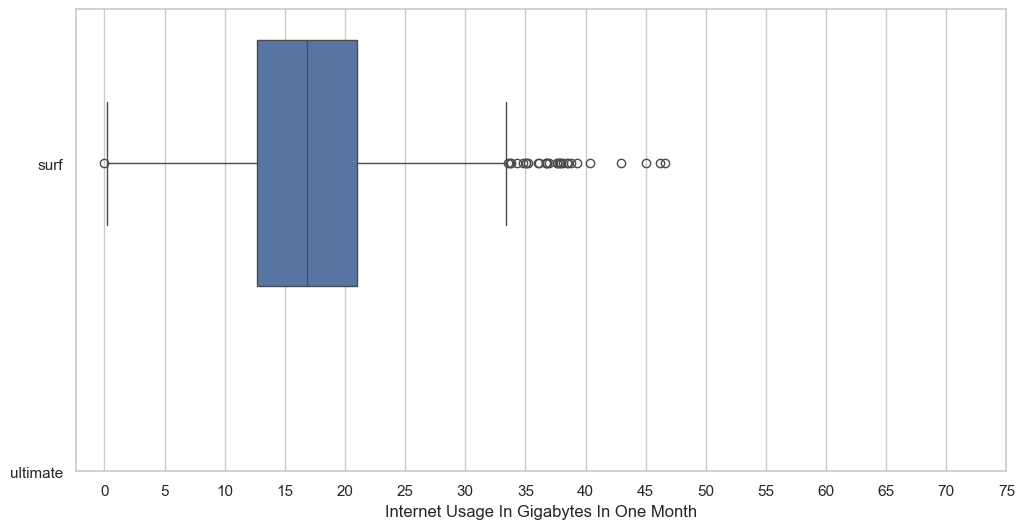

In [61]:
monthly_internet_boxplot = sns.boxplot(data = [monthly_internet_surf, monthly_internet_ultimate], orient = 'h')

plt.xlabel('Internet Usage In Gigabytes In One Month')
plt.xticks(np.arange(0, 80, step = 5))
plt.yticks([0, 1], labels = ['surf', 'ultimate'])
plt.show()

<b>Internet Conclusion</b> 
    
The distributions of Internet usage are very similar to each other. Just like the distributions for call minutes and messages sent, the Internet usage distributions are right–tailed. It makes sense that every distribution so far has been right–tailed because in the contexts of call minutes, messages sent, and Internet usage it is not possible for these values to be to the left of 0 on the number line, but in theory these values can go more and more to the right of the number line, approaching infinity.
    
As shown by the summary statistics DataFrame and the boxplot, both distributions have remarkably similar summary statistics. The mean and standard deviation, respectively, for the Surf plan are 16.558283 and 8.013513 whereas for Ultimate they are 17.2147 and 7.851897, respectively. Furthermore, even the quartile values are very similar: the quartile 1 values are 11.98652 for Surf and 12.666955 for Ultimate, the median values are 16.82931 and 16.85834, and the quartile 3 values are 20.99961 and 21.014527.
    
The results mentioned above bring me to the conclusion that Megaline customers are, on average, remarkably similar to one another with regards to monthly Internet usage, regardless of which plan they are subscribed to.
    
Unlike with call minutes and messages sent, there actually were Ultimate users who surpassed the monthly limit of 30 GB of Internet per month. As shown by the boxplot, there were quite a large number of outliers for the Ultimate plan, with the maximum value being	46.59533 GB used. Perhaps Megaline should consider increasing the monthly limit to something significantly more than 46.59533 GB, such as 60 GB, and begin charging more than 70 dollars per month? Doing this might come off as a better deal from the perspective of users.
    
The monthly limit for Surf users is 15 GB, yet the median number of gigabytes used in a month is 16.82931 meaning more than half of Surf users went over their limit. This is intriguing because enough though some Surf users went over their limit for call minutes and messages sent, the percentage who went over was MUCH lower than 50% for both quantities. 
    
It seems to me that between call minutes, messages sent, and Internet usage, Megaline users most commonly struggle the most with keeping within their Internet usage limits.

## Revenue

Let's use a bar graph to compare the average revenue per each plan per each distinct month.

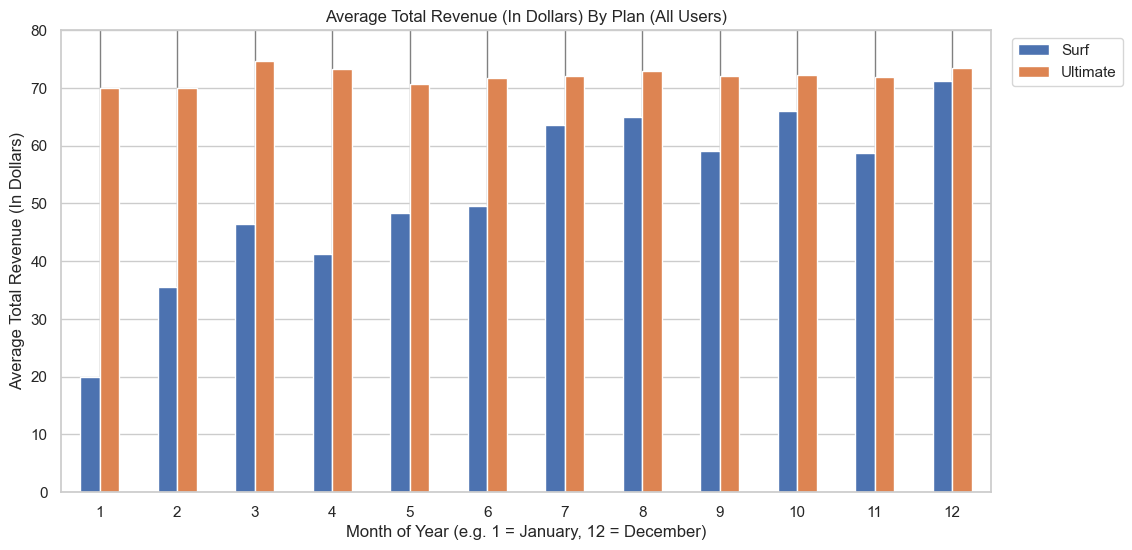

In [62]:
average_revenue = pd.DataFrame()
average_revenue = users_by_month[['plan_name', 'month', 'total_revenue']]

average_revenue_surf = average_revenue[average_revenue['plan_name'] == 'surf']
average_revenue_surf = average_revenue_surf.drop(columns = 'plan_name')
average_revenue_surf = average_revenue_surf.groupby('month').mean()
average_revenue_surf = average_revenue_surf.rename(columns = {'message_count': 'message_count_avg'})

average_revenue_ultimate = average_revenue[average_revenue['plan_name'] == 'ultimate']
average_revenue_ultimate = average_revenue_ultimate.drop(columns = 'plan_name')
average_revenue_ultimate = average_revenue_ultimate.groupby('month').mean()
average_revenue_ultimate = average_revenue_ultimate.rename(columns = {'total_revenue': 'avg_total_revenue'})

surf_and_ultimate_avg_revenue = pd.concat([average_revenue_surf, average_revenue_ultimate], 
                                           axis = 'columns')

surf_and_ultimate_avg_revenue.columns = ['surf_revenue_avg', 'ultimate_revenue_avg']

surf_and_ultimate_avg_revenue.plot(kind = 'bar',
                                   figsize = (12, 6),
                                   title = 'Average Total Revenue (In Dollars) By Plan (All Users)',
                                   xlabel = 'Month of Year (e.g. 1 = January, 12 = December)',
                                   ylabel = 'Average Total Revenue (In Dollars)',
                                   y = ['surf_revenue_avg', 'ultimate_revenue_avg'])

plt.grid(axis = 'x', color = 'gray')
plt.legend(['Surf', 'Ultimate'], bbox_to_anchor = (1.15, 1.0), loc = 'upper right')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 90, step = 10))
plt.show()

I deliberately plotted the distribution of revenue for the "Surf" and "Ultimate" plans in seperate histograms. A major reason why I did this has to do with how (as shown below) the "Surf" revenue values overwhelmingly cluster on or around 20 dollars, with a wide range of possible values (the maximum being 600.37 dollars), whereas the "Ultimate" revenue values overwhelmingly cluster on or around $70, with much less of a range of possible values (the maximum being 182 dollars). Hence, I deemed it appropriate to make two seperate histograms with different x–axis values (and slightly different y–axis values).

Furthermore, I decided to have the x–axis of Ultimate's histogram contain all of the values that appear in the DataFrame, however I truncated the x–axis values of Surf's histogram for two reasons. (1) The 75th percentile revenue value for Surf is 81.95 dollars, so stopping the histogram's x–axis at 135 dollars still shows the overwhelming majority of the data values, definitely enough to get an accurate idea of the distribution. (2) If I included all of the x–values, including the maximum of 600.37, the histogram would look "squished" and awkward.

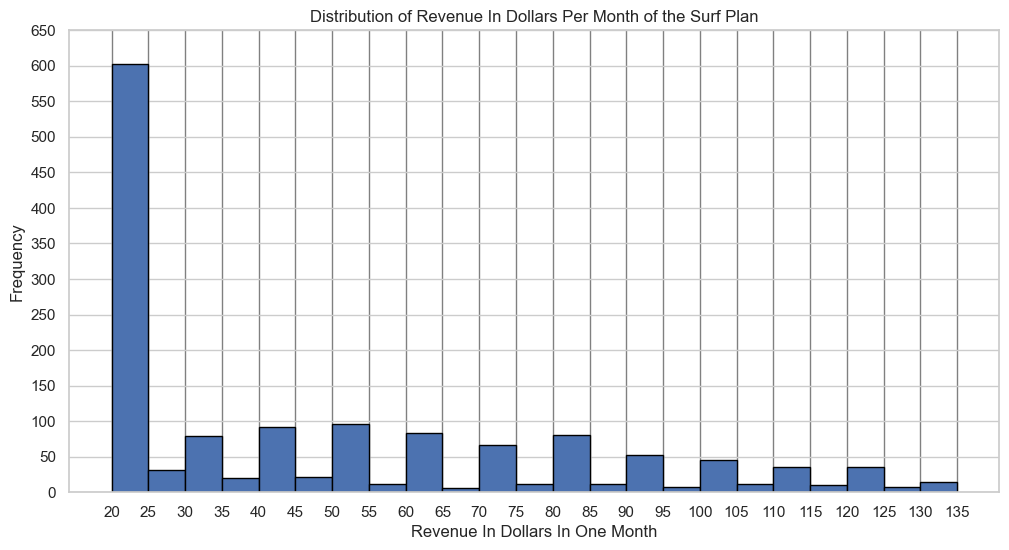

In [63]:
monthly_revenue_surf = pd.DataFrame()
monthly_revenue_surf = users_by_month[users_by_month['plan_name'] == 'surf']['total_revenue']
monthly_revenue_surf = monthly_revenue_surf.reset_index(drop = True)

monthly_revenue_surf.plot(kind = 'hist',
                          bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
                                  85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135],
                          edgecolor = 'black',
                          figsize = (12, 6),
                          title = 'Distribution of Revenue In Dollars Per Month of the Surf Plan')

plt.grid(axis = 'x', color = 'gray')
plt.xlabel('Revenue In Dollars In One Month')
plt.xticks(np.arange(20, 140, step = 5))
plt.yticks(np.arange(0, 700, step = 50))
plt.show()

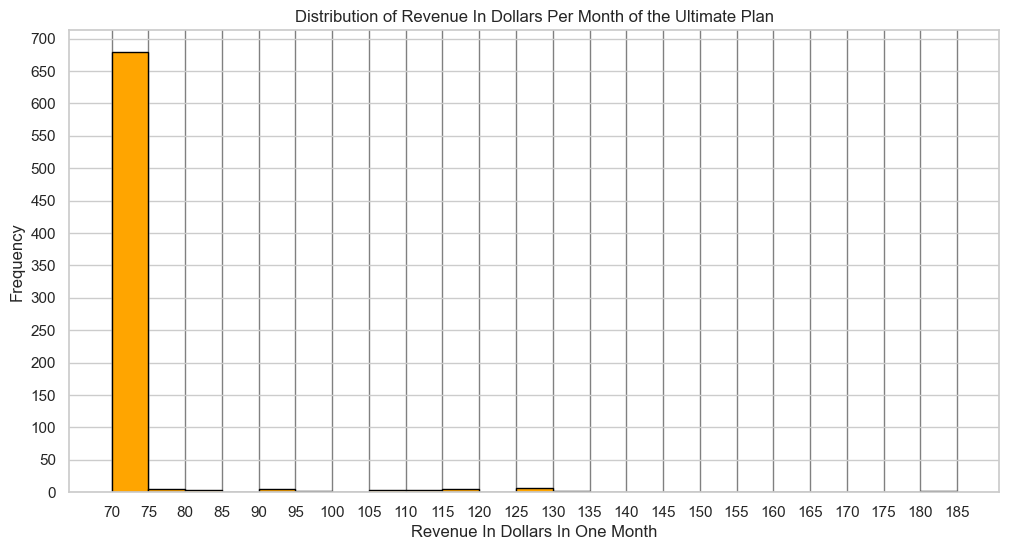

In [64]:
monthly_revenue_ultimate = pd.DataFrame()
monthly_revenue_ultimate = users_by_month[users_by_month['plan_name'] == 'ultimate']['total_revenue']
monthly_revenue_ultimate = monthly_revenue_ultimate.reset_index(drop = True)

monthly_revenue_ultimate.plot(kind = 'hist',
                              bins = [70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130,
                                      135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185],
                              color = 'orange',
                              edgecolor = 'black',
                              figsize = (12, 6),
                              title = 'Distribution of Revenue In Dollars Per Month of the Ultimate Plan')

plt.grid(axis = 'x', color = 'gray')
plt.xlabel('Revenue In Dollars In One Month')
plt.xticks(np.arange(70, 190, step = 5))
plt.yticks(np.arange(0, 750, step = 50))
plt.show()

In [65]:
monthly_revenue_summary_stats = pd.DataFrame()

monthly_revenue_summary_stats['plan_name'] = ['surf', 'ultimate']

monthly_revenue_summary_stats['count'] = [monthly_revenue_surf.count(), monthly_revenue_ultimate.count()]

monthly_revenue_summary_stats['mean'] = [monthly_revenue_surf.mean(), monthly_revenue_ultimate.mean()]

monthly_revenue_summary_stats['variance'] = [monthly_revenue_surf.var(), monthly_revenue_ultimate.var()]

monthly_revenue_summary_stats['standard_deviation'] = [monthly_revenue_surf.std(), monthly_revenue_ultimate.std()]

monthly_revenue_summary_stats['minimum'] = [monthly_revenue_surf.min(), monthly_revenue_ultimate.min()]

monthly_revenue_summary_stats['25th_Percentile'] = [np.percentile(monthly_revenue_surf, 25), np.percentile(monthly_revenue_ultimate, 25)]

monthly_revenue_summary_stats['50th_Percentile'] = [monthly_revenue_surf.median(), monthly_revenue_ultimate.median()]

monthly_revenue_summary_stats['75th_Percentile'] = [np.percentile(monthly_revenue_surf, 75), np.percentile(monthly_revenue_ultimate, 75)]

monthly_revenue_summary_stats['maximum'] = [monthly_revenue_surf.max(), monthly_revenue_ultimate.max()]

display(monthly_revenue_summary_stats)

,plan_name,count,mean,variance,standard_deviation,minimum,25th_Percentile,50th_Percentile,75th_Percentile,maximum
0,surf,1573,61.431138,3198.677644,56.556853,20.0,20.0,40.51,81.95,600.37
1,ultimate,720,72.381944,137.638338,11.731937,70.0,70.0,70.00,70.00,182.00


For reasons similar to those of the histograms above, I decided to put the revenue values of the Surf and Ulimate plans into seperate boxplots. One major difference between the following boxplots and the histograms above is that I deliberately decided not to truncate the x–axis values of Surf's revenue so to visualize how far away the outliers are from the majority of the data set.
    
Also worth noting is that I deliberately gave the xticks of Ultimate's boxplot a step value of 5 because this choice, I think, very nicely visualizes how the overwhelming majority of users with the Ultimate plan do not find themselves paying more than the 70 dollar monthly fee each month.

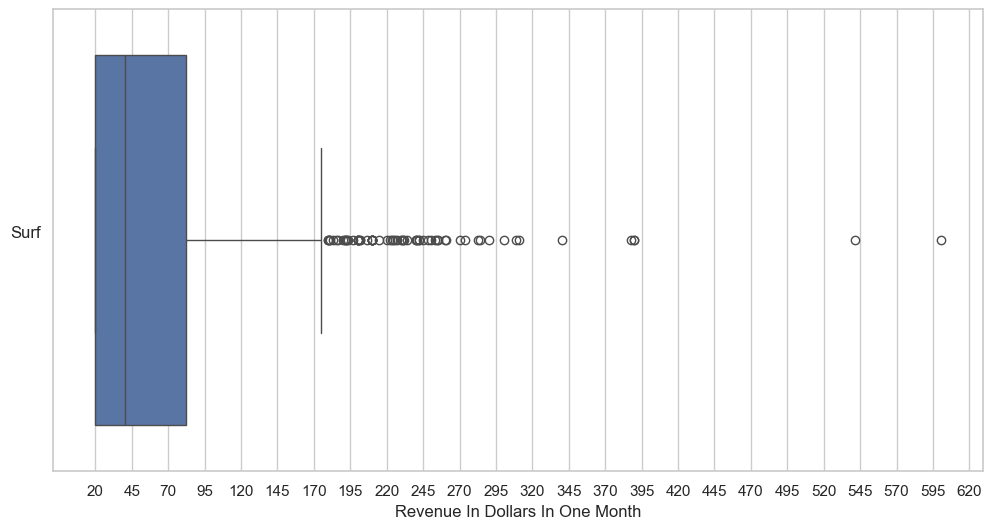

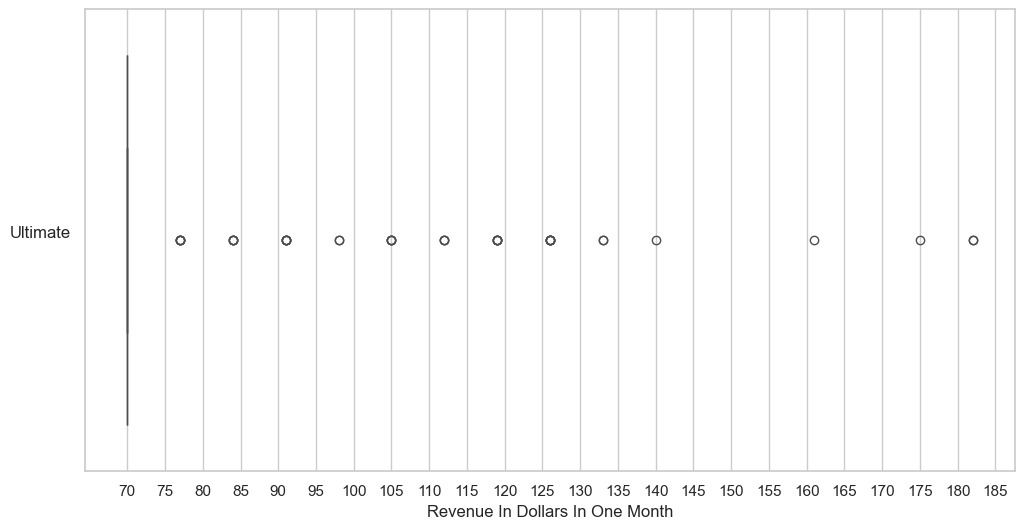

In [66]:
monthly_revenue_boxplot = sns.boxplot(data = monthly_revenue_surf, orient = 'h')
plt.xlabel('Revenue In Dollars In One Month')
plt.xticks(np.arange(20, 645, step = 25))
plt.yticks([])
plt.ylabel('Surf', rotation = 0, labelpad = 20.0)
plt.show()

monthly_revenue_boxplot = sns.boxplot(data = monthly_revenue_ultimate, orient = 'h', color = 'orange')
plt.xlabel('Revenue In Dollars In One Month')
plt.xticks(np.arange(70, 190, step = 5))
plt.yticks([])
plt.ylabel('Ultimate', rotation = 0, labelpad = 32.0)
plt.show()

<b>Revenue Conclusion</b> 
    
Compared to the distributions shown earlier in the project, the distributions of revenue are, hands down, the most different. Broadly speaking, it is rare for a person with the Ultimate plan to find themselves paying more than the monthly fee of 70 dollars, however it is quite common for a person with the Surf plan to find themselves paying more than their monthly fee of 20 dollars. In fact, when it comes to Surf users it is more common to pay more than 20 dollars per month than it is to pay only the 20 dollar monthly fee.
    
As funny as this might sound, the quartile 1, median, and quartile 3 values for the Ultimate plan ALL equal 70, meaning at least 75% of Ultimate users do not go over the limits of their package and only pay the 70 dollars monthly fee. Even when an Ultimate user does end up paying more than 70 dollars in a month, it is usually not much more than 70. The histogram shows that over 90% of Ultimate users paid between 70 and 75 dollars for a month's worth of Megaline's services.
    
Though the Ultimate revenue distribution has some outliers, outliers are far more prevalent and extreme in the Surf distribution. The extremeness of the outliers in the Surf distribution is hinted at by the fact that the mean revenue of 61.431138 dollars is much higher than the median revenue of 40.51 dollars. Speaking of the median, it is correct to say that at least half of Surf users found themselves paying at least double the cost of the 20 dollar monthly fee.
    
Finally, notice that the quartile 1 value of the Surf distribution is 20 dollars. That means 25% of Surf users did not go over their monthly limits and paid only the monthly fee. On the flip side, that means 75% of them, a clear majority, went over at least one of their three limits (most commonly the Internet limit), and hence had to pay something more than just the 20 dollar monthly fee.

## Test statistical hypotheses

In this section, I am tasked with using the samples I have of the revenues of the Surf and Ultimate plans to test hypotheses regarding the average revenues of the populations of the plans.
    
(I) For the first task, my hypotheses are the following:
    
<u>NULL</u>: The average revenue from users of the Surf and Ultimate calling plans are equal.
    
<u>ALTERNATIVE</u>: The average revenue from users of the Surf and Ultimate calling plans are <b>NOT</b> equal.
    
I will set the p–value equal to 0.05 because this is the most commonly used p–value, and I see no good reason to use a different one.
    
I will set equal_var equal to "False" because the variance values of the revenues of the two plans are <b>VASTLY</b> different. (3198.68 dollars for the Surf plan, but only 137.64	dollars for the Ultimate plan.)
    
Finally, this is a TWO–tailed hypothesis because it is possible that the average revenue of the Surf plan is much higher than that of Ultimate, but it is also possible that the average is much lower, hence two "tails".
    
(II) For the second task, my hypotheses are the following:
    
<u>NULL</u>: The average revenue from users in the NY-NJ area is equal to that of the users from the other regions.
    
<u>ALTERNATIVE</u>: The average revenue from users in the NY-NJ area is <b>NOT</b> equal to that of the users from the other regions.
    
Once again, I will set the p–value equal to 0.05, and once more this is a two–tailed hypothesis.
    
Finally, I will set equal_var equal to "True" because, as you will see below, I used both the Bartlett and the Levene test which brought me to the conclusion that I cannot reject the (null) hypothesis that the variances are equal.

**First Hypothesis Test**

In [67]:
test_1 = st.ttest_ind(monthly_revenue_surf, monthly_revenue_ultimate, equal_var = False)

print('p-value:', test_1.pvalue)

test_1_p_value = 0.05

if test_1.pvalue < test_1_p_value:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

p-value: 3.140022256428878e-13
We reject the null hypothesis.


**Second Hypothesis Test**

First, I need to determine which users live in the NY-NJ area and which do not.

In [68]:
test_2_NY_NJ_data = pd.DataFrame()
test_2_NY_NJ_data = users[['user_id', 'city']].copy()
test_2_NY_NJ_data = test_2_NY_NJ_data[test_2_NY_NJ_data['city'].str.contains('NY|NJ')]
test_2_NY_NJ_data = test_2_NY_NJ_data.sort_values(by = 'user_id', ascending = True)

test_2_other_data = pd.DataFrame()
test_2_other_data = users[['user_id', 'city']].copy()
test_2_other_data = test_2_other_data[~test_2_other_data['city'].str.contains('NY|NJ')]
test_2_other_data = test_2_other_data.sort_values(by = 'user_id', ascending = True)

display(test_2_NY_NJ_data)
display(test_2_other_data)

,user_id,city
14,1014,"New York-Newark-Jersey City, NY-NJ-PA USA"
22,1022,"New York-Newark-Jersey City, NY-NJ-PA USA"
24,1024,"New York-Newark-Jersey City, NY-NJ-PA USA"
27,1027,"New York-Newark-Jersey City, NY-NJ-PA USA"
28,1028,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD USA"
...,...,...
469,1469,"New York-Newark-Jersey City, NY-NJ-PA USA"
482,1482,"New York-Newark-Jersey City, NY-NJ-PA USA"
494,1494,"New York-Newark-Jersey City, NY-NJ-PA USA"
495,1495,"New York-Newark-Jersey City, NY-NJ-PA USA"


,user_id,city
0,1000,"Atlanta-Sandy Springs-Roswell, GA USA"
1,1001,"Seattle-Tacoma-Bellevue, WA USA"
2,1002,"Las Vegas-Henderson-Paradise, NV USA"
3,1003,"Tulsa, OK USA"
4,1004,"Seattle-Tacoma-Bellevue, WA USA"
...,...,...
492,1492,"Portland-Vancouver-Hillsboro, OR-WA USA"
493,1493,"Boston-Cambridge-Newton, MA-NH USA"
496,1496,"New Orleans-Metairie, LA USA"
497,1497,"Los Angeles-Long Beach-Anaheim, CA USA"


Next, I compute the average monthly revenue of each user.

In [69]:
average_revenue_per_user = users_by_month[['user_id', 'total_revenue']]
average_revenue_per_user = average_revenue_per_user.groupby('user_id').mean()
average_revenue_per_user = average_revenue_per_user.rename(columns = {'total_revenue':'avg_revenue'})
average_revenue_per_user = average_revenue_per_user.reset_index()

display(average_revenue_per_user)

,user_id,avg_revenue
0,1000,70.000000
1,1001,52.018000
2,1002,33.333333
3,1003,158.120000
4,1004,78.750000
...,...,...
485,1495,118.325000
486,1496,28.000000
487,1497,70.000000
488,1498,78.181818


Now I can merge the **test_2_NY_NJ_data** DataFrame with **average_revenue_per_user**, as well as merge the **test_2_other_data** DataFrame with **average_revenue_per_user**.

In [70]:
test_2_NY_NJ_data = test_2_NY_NJ_data.merge(average_revenue_per_user, how = 'outer')
test_2_NY_NJ_data = test_2_NY_NJ_data[~test_2_NY_NJ_data['city'].isna()]
test_2_NY_NJ_data = test_2_NY_NJ_data.fillna(0)

test_2_other_data = test_2_other_data.merge(average_revenue_per_user, how = 'outer')
test_2_other_data = test_2_other_data[~test_2_other_data['city'].isna()]
test_2_other_data = test_2_other_data.fillna(0)

display(test_2_NY_NJ_data)
display(test_2_other_data)

,user_id,city,avg_revenue
14,1014,"New York-Newark-Jersey City, NY-NJ-PA USA",29.420000
22,1022,"New York-Newark-Jersey City, NY-NJ-PA USA",57.375000
24,1024,"New York-Newark-Jersey City, NY-NJ-PA USA",21.920000
26,1027,"New York-Newark-Jersey City, NY-NJ-PA USA",33.333333
27,1028,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD USA",120.909091
...,...,...,...
461,1469,"New York-Newark-Jersey City, NY-NJ-PA USA",100.000000
473,1482,"New York-Newark-Jersey City, NY-NJ-PA USA",70.000000
485,1494,"New York-Newark-Jersey City, NY-NJ-PA USA",32.291667
486,1495,"New York-Newark-Jersey City, NY-NJ-PA USA",118.325000


,user_id,city,avg_revenue
0,1000,"Atlanta-Sandy Springs-Roswell, GA USA",70.000000
1,1001,"Seattle-Tacoma-Bellevue, WA USA",52.018000
2,1002,"Las Vegas-Henderson-Paradise, NV USA",33.333333
3,1003,"Tulsa, OK USA",158.120000
4,1004,"Seattle-Tacoma-Bellevue, WA USA",78.750000
...,...,...,...
491,1492,"Portland-Vancouver-Hillsboro, OR-WA USA",25.000000
492,1493,"Boston-Cambridge-Newton, MA-NH USA",70.000000
495,1496,"New Orleans-Metairie, LA USA",28.000000
496,1497,"Los Angeles-Long Beach-Anaheim, CA USA",70.000000


I need to find the variance of the average revenue values for both the **test_2_NY_NJ_data** and the **test_2_other_data** DataFrames because when I do the test I need to decide if the **equal_var** argument should be set equal to "True" or "False". The code below stores the variance values in a DataFrame, as well as the mean and standard deviation values.

In [71]:
test_2_variance = pd.DataFrame()
test_2_variance['region'] = ['NY&NJ', 'Other']
test_2_variance['mean_revenue_per_user'] = [test_2_NY_NJ_data['avg_revenue'].mean(), test_2_other_data['avg_revenue'].mean()]
test_2_variance['variance'] = [test_2_NY_NJ_data['avg_revenue'].var(), test_2_other_data['avg_revenue'].var()]
test_2_variance['standard_deviation'] = [test_2_NY_NJ_data['avg_revenue'].std(), test_2_other_data['avg_revenue'].std()]

display(test_2_variance)

,region,mean_revenue_per_user,variance,standard_deviation
0,NY&NJ,60.056618,1259.184438,35.484989
1,Other,62.204275,1495.816631,38.675789


Unlike the first hypothesis test, here it is difficult to intuitively tell if the variances should be treated as equals or not. One can argue that the mean and standard deviation values are close enough to each other that the variances should be treated as equals, but it is better to use a more robust method in this situation. The code below runs the Bartlett and Levene tests. Perhaps I didn't HAVE TO run both tests, but running both gives me reassurance. 

In [72]:
from scipy.stats import bartlett
from scipy.stats import levene

bartlett_var_p_value = bartlett(test_2_NY_NJ_data['avg_revenue'], test_2_other_data['avg_revenue']).pvalue
levene_var_p_value = levene(test_2_NY_NJ_data['avg_revenue'], test_2_other_data['avg_revenue']).pvalue

alpha = 0.05

print('Bartlett p–value:', bartlett_var_p_value)
if bartlett_var_p_value < alpha:
    print('We reject the null hypothesis that the variances are equal.')
else:
    print('We fail to reject the null hypothesis that the variances are equal.')

print()
    
print('Levene p–value:', levene_var_p_value)
if levene_var_p_value < alpha:
    print('We reject the null hypothesis that the variances are equal.')
else:
    print('We fail to reject the null hypothesis that the variances are equal.')

Bartlett p–value: 0.2818717072243901
We fail to reject the null hypothesis that the variances are equal.

Levene p–value: 0.5211978923774945
We fail to reject the null hypothesis that the variances are equal.


I now have everything I need to test the null hypothesis.

In [73]:
test_2 = st.ttest_ind(test_2_NY_NJ_data['avg_revenue'], test_2_other_data['avg_revenue'], equal_var = True)

print('p-value:', test_2.pvalue)

test_2_p_value = 0.05

if test_2.pvalue < test_2_p_value:    
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

p-value: 0.609918072949066
We fail to reject the null hypothesis.


## Conclusion

As an analyst for the telecom operator Megaline, I was assigned to carry out a preliminary analysis of the two prepaid plans Megaline offers, Surf and Ultimate, using the data of a random sample of 500 Megaline clients. The data includes who the clients are, which plan they use, the duration of their phone calls, when they sent a message, and how many megabytes they used with each Internet session. Ultimately, my analysis is intended to help the commerical department realize which plan brings in more revenue so that they can adjust the advertising budget accordingly.

My analysis brings me to the conclusion that the commerical department should focus their attention on the Ultimate plan, as that is the one which, on average, brings in more revenue. When rounded to two decimal places, the average monthly revenue acquired from an Ultimate user is 72.38 dollars, whereas for Surf users that number is only 61.43 dollars. I examined this result using a two–tailed t–test with the following null hypothesis: "The average revenue from users of the Surf and Ultimate calling plans are equal." The resulting p–value was so close to 0 that I rejected the null hypothesis, which in turn gives reason to believe it is normal for the Ultimate plan to bring in more revenue.

Worth sharing is an idea I have to increase revenue while simultaneously improving customer satisfaction. I noticed in this sample that not one Ultimate plan user went over their limit with call minutes and messages, but many of them did go over their gigabytes of Internet usage. This plan limits Internet usage to 30 GB, but one user used as many as 46.59533 GB. Perhaps Megaline should consider advertising to its clients that they will increase the limit from 30 GB to 50 GB, and begin charging 80 dollars per month instead of 70. Over 90% of Ultimate users bring in a monthly revenue between 70 and 75 dollars, so changing the monthly fee to 80 dollars is sure to bring in more revenue. From the perspective of customers, an increase from 30 GB to 50 GB is likely to come off as very generous and worth the additional 10 dollars. 

Perhaps Megaline should consider raising the monthly fee for the Surf plan, and in return increasing one, two, or even all three of the current limits. That might help the Surf plan begin bringing in just as much if not more revenue than the Ultimate plan, but for right now the commercial department should focus its attention on the Ultimate plan.